In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import model_selection, preprocessing
from sklearn.metrics import mean_squared_error
import math

%matplotlib inline

In [3]:
hourly = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\daily_station35.csv")
hourly.head()

,startday,from_station_id,num_trips,from_station_name,from_station_latitude,from_station_longitude
0,2013-08-05,35,64,Streeter Dr & Grand Ave,41.892278,-87.612043
1,2013-08-06,35,169,Streeter Dr & Grand Ave,41.892278,-87.612043
2,2013-08-07,35,117,Streeter Dr & Grand Ave,41.892278,-87.612043
3,2013-08-08,35,193,Streeter Dr & Grand Ave,41.892278,-87.612043
4,2013-08-09,35,238,Streeter Dr & Grand Ave,41.892278,-87.612043


In [4]:
#any null value?
hourly.isnull().sum()
hourly.startday =  pd.to_datetime(hourly.startday, errors="coerce")
hourly.dtypes

startday                  datetime64[ns]
from_station_id                    int64
num_trips                          int64
from_station_name                 object
from_station_latitude            float64
from_station_longitude           float64
dtype: object

In [5]:
#feature engineering
#Dervice weekday and weekend
#convert column data into appropriate
dateTimeIndex = pd.DatetimeIndex(hourly['startday'])
hourly["day"] = dateTimeIndex.dayofweek
hourly["month"] = dateTimeIndex.month
hourly['year']= dateTimeIndex.year
hourly["day_name"] = dateTimeIndex.dayofweek
hourly["tripdate"] = dateTimeIndex.day

hourly.head()

,startday,from_station_id,num_trips,from_station_name,from_station_latitude,from_station_longitude,day,month,year,day_name,tripdate
0,2013-08-05,35,64,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,0,5
1,2013-08-06,35,169,Streeter Dr & Grand Ave,41.892278,-87.612043,1,8,2013,1,6
2,2013-08-07,35,117,Streeter Dr & Grand Ave,41.892278,-87.612043,2,8,2013,2,7
3,2013-08-08,35,193,Streeter Dr & Grand Ave,41.892278,-87.612043,3,8,2013,3,8
4,2013-08-09,35,238,Streeter Dr & Grand Ave,41.892278,-87.612043,4,8,2013,4,9


In [6]:
#define weekday
weekday_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_dict = {key: weekday_name[key] for key in range(7)}

def day_of_week(idx):
    return weekday_dict[idx]
hourly.day_name = hourly.day_name.apply(day_of_week)


In [7]:
#function to define seasons
def date2season(df):
    #dateTimeIndex = pd.DatetimeIndex(df)
  
    md = df.month * 100 + df.day

    if (md > 320 and md < 621):
        s = 0    #Spring
    elif (md > 620 and md < 923):
        s = 1   #Summer
    elif (md > 922 and md < 1223):
        s = 2   #Fall
    else:
        s = 3   #Winter

        '''
    if hemisphere != 'north':
        if s < 2:
            s += 2 
        else:
            s -= 2
        '''
    return s

d1 = hourly.startday.apply(date2season)
hourly["season"] = d1


In [8]:
#define weekday
seasons = ["Spring", "Summer", "Fall", "Winter"]
season_dict = {key: seasons[key] for key in range(4)}

def season_name(idx):
    return season_dict[idx]

hourly["seasons_name"] = hourly.season.apply(season_name)


In [9]:
#Finding hoildays
#pip install holidays
#package holidays 0.8.1

import holidays as hh
holidaysArr = []

for x in (2013, 2014, 2015, 2016, 2017):
    for date, name in sorted(hh.US(state='IL', years=x).items()):
        holidaysArr.append(date)

holidays_US = pd.DatetimeIndex(holidaysArr)

def USHolidays(startday):
    dt = pd.to_datetime(startday)
    i = 0
    if dt in holidays_US :
        i = 1    #holiday
    
    return i

hourly["IsHoliday"] = hourly.startday.apply(USHolidays)

In [10]:
#Weather data
wt = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\weatherDataDaily.csv")
wt.startday =  pd.to_datetime(wt.startday, errors="coerce")

resultData = pd.merge(hourly, wt, on=['startday'])
#resultData.head()

In [11]:
# Create a set of dummy variables from the weather feature
df_weather = pd.get_dummies(resultData['weather'])
df_weather.head()

,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [12]:
#join dummy dataframe in original
resultData_new = pd.concat([resultData, df_weather], axis=1)
#resultData.drop('weatherCode', axis=1)
resultData_new.dtypes

startday                  datetime64[ns]
from_station_id                    int64
num_trips                          int64
from_station_name                 object
from_station_latitude            float64
from_station_longitude           float64
day                                int32
month                              int32
year                               int32
day_name                          object
tripdate                           int32
season                             int64
seasons_name                      object
IsHoliday                          int64
weather                           object
humidity                         float64
temperatureMax                   float64
temperatureMin                   float64
windspeed                        float64
CLEAR_DAY                          uint8
FOG                                uint8
PARTLY_CLOUDY_DAY                  uint8
PARTLY_CLOUDY_NIGHT                uint8
RAIN                               uint8
SNOW            

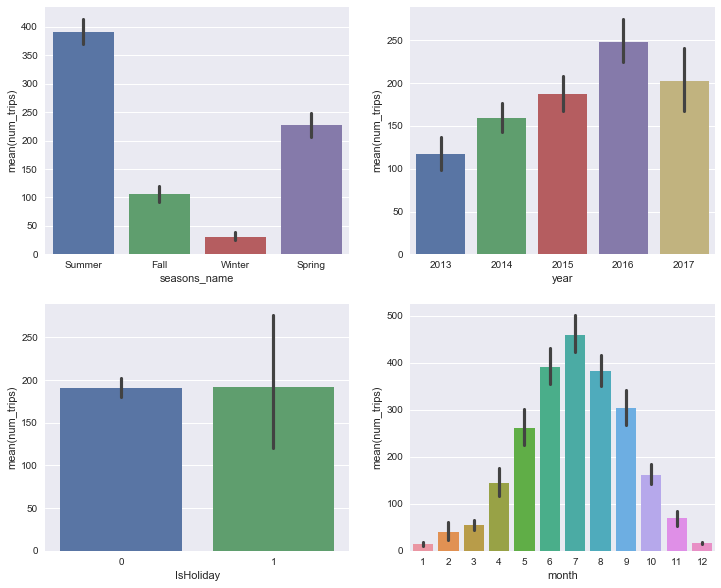

In [13]:
#at from_station_id=35
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.barplot(data=resultData_new, y="num_trips", x="seasons_name",orient="v",ax=axes[0][0])
sns.barplot(data=resultData_new, y="num_trips", x="year",orient="v",ax=axes[0][1])
sns.barplot(data=resultData_new, y="num_trips", x="IsHoliday", orient="v",ax=axes[1][0])
sns.barplot(data=resultData_new, y="num_trips", x="month",orient="v",ax=axes[1][1])

               weather  num_trips
0            CLEAR_DAY      87119
2    PARTLY_CLOUDY_DAY      78003
6                 WIND      39979
4                 RAIN      38077
3  PARTLY_CLOUDY_NIGHT      17908
1                  FOG       3459
5                 SNOW        138


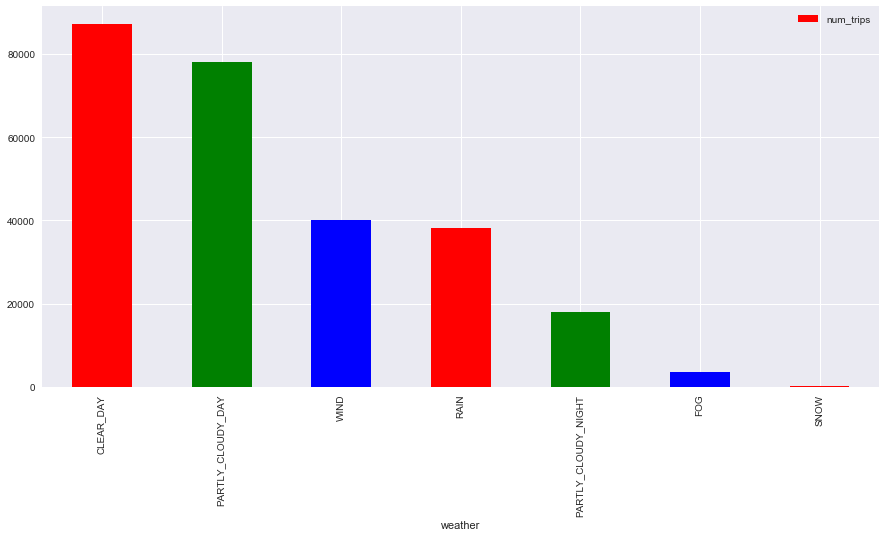

In [14]:
df_weathergrouped = resultData_new.groupby('weather').num_trips.sum().to_frame()
df_weathergrouped.sort_values

weather_df_sorted = df_weathergrouped.reset_index('weather').sort_values(['num_trips'], 
                                                                         ascending = [False])
print(weather_df_sorted)
#fig1, axes = plt.subplots(nrows=1, ncols=1)
#fig1.set_size_inches(15, 10)

weather_df_sorted.plot.bar(x='weather', y='num_trips', figsize=(15, 7), color='rgb')
#sns.barplot(data=df_top5, y="num_trips", x="weather",orient="v")
#plt.show()

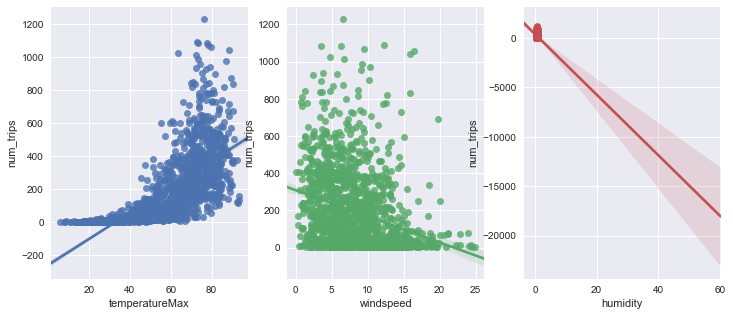

In [15]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temperatureMax", y="num_trips", data=resultData,ax=ax1)
sns.regplot(x="windspeed", y="num_trips", data=resultData,ax=ax2)
sns.regplot(x="humidity", y="num_trips", data=resultData,ax=ax3)

In [16]:
#Categorize variables
categoricalVariables = ["from_station_id","from_station_name","month", "year", "season", "seasons_name", "IsHoliday",
                       "weather", "day_name", "day", "tripdate", 'CLEAR_DAY', 'FOG',
       'PARTLY_CLOUDY_DAY', 'PARTLY_CLOUDY_NIGHT', 'RAIN', 'SNOW', 'WIND']
for var in categoricalVariables:
    resultData_new[var] = resultData_new[var].astype("category")

resultData_new.dtypes


startday                  datetime64[ns]
from_station_id                 category
num_trips                          int64
from_station_name               category
from_station_latitude            float64
from_station_longitude           float64
day                             category
month                           category
year                            category
day_name                        category
tripdate                        category
season                          category
seasons_name                    category
IsHoliday                       category
weather                         category
humidity                         float64
temperatureMax                   float64
temperatureMin                   float64
windspeed                        float64
CLEAR_DAY                       category
FOG                             category
PARTLY_CLOUDY_DAY               category
PARTLY_CLOUDY_NIGHT             category
RAIN                            category
SNOW            

In [17]:
#Outlier are present, will check with model, how model is better without outliers
resultDataWithoutOutliers = resultData_new[np.abs(resultData_new["num_trips"]-resultData_new["num_trips"].mean())
                                           <=(3*resultData_new["num_trips"].std())]

print("Before Ouliers removal: ",resultData.shape)
print("After Ouliers removal: ",resultDataWithoutOutliers.shape)


Before Ouliers removal:  (1384, 19)
After Ouliers removal:  (1361, 26)


In [18]:
#Correlation Analysis

df_numerical = resultData_new.drop(['from_station_longitude', 'from_station_name', 'from_station_id', 'year', 'day', 'day_name', 'seasons_name', 
                     'from_station_latitude', 'weather'], axis=1)

df_numerical.head()
df_numerical.corr()

,num_trips,humidity,temperatureMax,temperatureMin,windspeed
num_trips,1.000000,-0.165255,0.700211,0.683838,-0.282625
humidity,-0.165255,1.000000,-0.011761,0.093552,-0.080563
temperatureMax,0.700211,-0.011761,1.000000,0.954309,-0.238417
temperatureMin,0.683838,0.093552,0.954309,1.000000,-0.266157
windspeed,-0.282625,-0.080563,-0.238417,-0.266157,1.000000


In [19]:
df_numerical.set_index(['startday'])
df_sorted = df_numerical.sort_index(level='startday')

df_sorted.head()

,startday,num_trips,month,tripdate,season,IsHoliday,humidity,temperatureMax,temperatureMin,windspeed,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND
0,2013-08-05,64,8,5,1,0,0.71,73.41,62.73,7.32,1,0,0,0,0,0,0
1,2013-08-06,169,8,6,1,0,0.78,81.36,67.74,7.29,1,0,0,0,0,0,0
2,2013-08-07,117,8,7,1,0,0.77,83.63,69.75,2.13,1,0,0,0,0,0,0
3,2013-08-08,193,8,8,1,0,0.64,73.02,67.75,10.33,1,0,0,0,0,0,0
4,2013-08-09,238,8,9,1,0,0.63,78.74,64.03,1.06,1,0,0,0,0,0,0


In [20]:
#defining method to Test for stationary with ADF test
from statsmodels.tsa.stattools import adfuller
def isStationary(tsData):

    rollingmean = pd.rolling_mean(tsData, window=7, min_periods=1)
    fig = plt.figure(figsize=(15, 8))
    orig = plt.plot(tsData, color='blue',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Timeseries data')
    plt.show()
    
    print('ADF Test result:')
    
    result = adfuller(tsData, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
        
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    

C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()


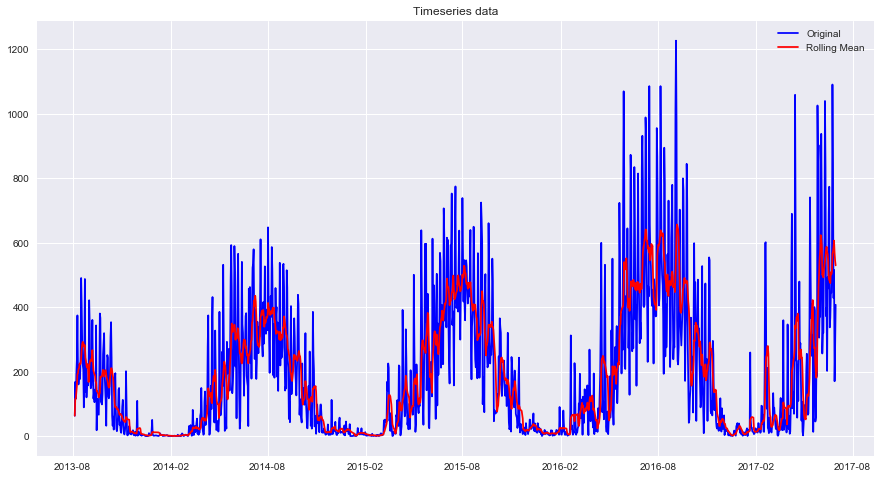

ADF Test result:
ADF Statistic: -1.779845
p-value: 0.390513
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [21]:
#Test for stationary with ADF test
#H0: timeseries data is non-stationary
#H1 timeserise data is stationary

#as p-value is > 0.05
#fail to reject null-hypothesis
#i.e. Data is non-stationary

#Perform Dickey-Fuller test on original data

t4 = df_sorted.groupby(['startday']).num_trips.sum().to_frame()
index_df = df_sorted.set_index('startday')
isStationary(index_df.num_trips)

In [22]:
#timeseries data is not stationary. first make it stationary. and then split

index_df['diff_num_trips_1'] = index_df.num_trips.diff(periods=1)
index_df['diff_num_trips_2'] = index_df.num_trips.diff(periods=2)
index_df['diff_num_trips_3'] = index_df.num_trips.diff(periods=3)
index_df['diff_num_trips_4'] = index_df.num_trips.diff(periods=4)

index_df['diff_num_trips_1'] = index_df.diff_num_trips_1.fillna(0)
index_df['diff_num_trips_2'] = index_df.diff_num_trips_2.fillna(0)
index_df['diff_num_trips_3'] = index_df.diff_num_trips_3.fillna(0)
index_df['diff_num_trips_4'] = index_df.diff_num_trips_4.fillna(0)
index_df.head()

,num_trips,month,tripdate,season,IsHoliday,humidity,temperatureMax,temperatureMin,windspeed,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,diff_num_trips_1,diff_num_trips_2,diff_num_trips_3,diff_num_trips_4
startday,,,,,,,,,,,,,,,,,,,,
2013-08-05,64,8,5,1,0,0.71,73.41,62.73,7.32,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2013-08-06,169,8,6,1,0,0.78,81.36,67.74,7.29,1,0,0,0,0,0,0,105.0,0.0,0.0,0.0
2013-08-07,117,8,7,1,0,0.77,83.63,69.75,2.13,1,0,0,0,0,0,0,-52.0,53.0,0.0,0.0
2013-08-08,193,8,8,1,0,0.64,73.02,67.75,10.33,1,0,0,0,0,0,0,76.0,24.0,129.0,0.0
2013-08-09,238,8,9,1,0,0.63,78.74,64.03,1.06,1,0,0,0,0,0,0,45.0,121.0,69.0,174.0


C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()


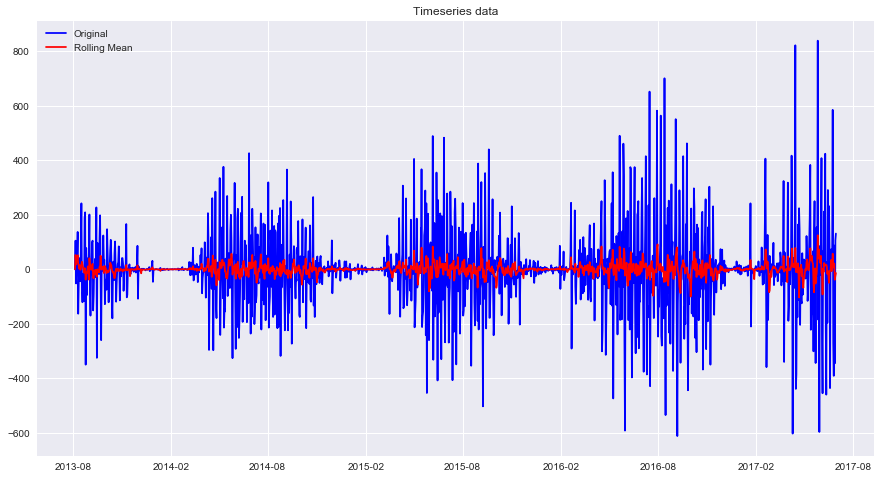

ADF Test result:
ADF Statistic: -10.755449
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [23]:
index_df.dropna(inplace=True)
isStationary(index_df.diff_num_trips_1)

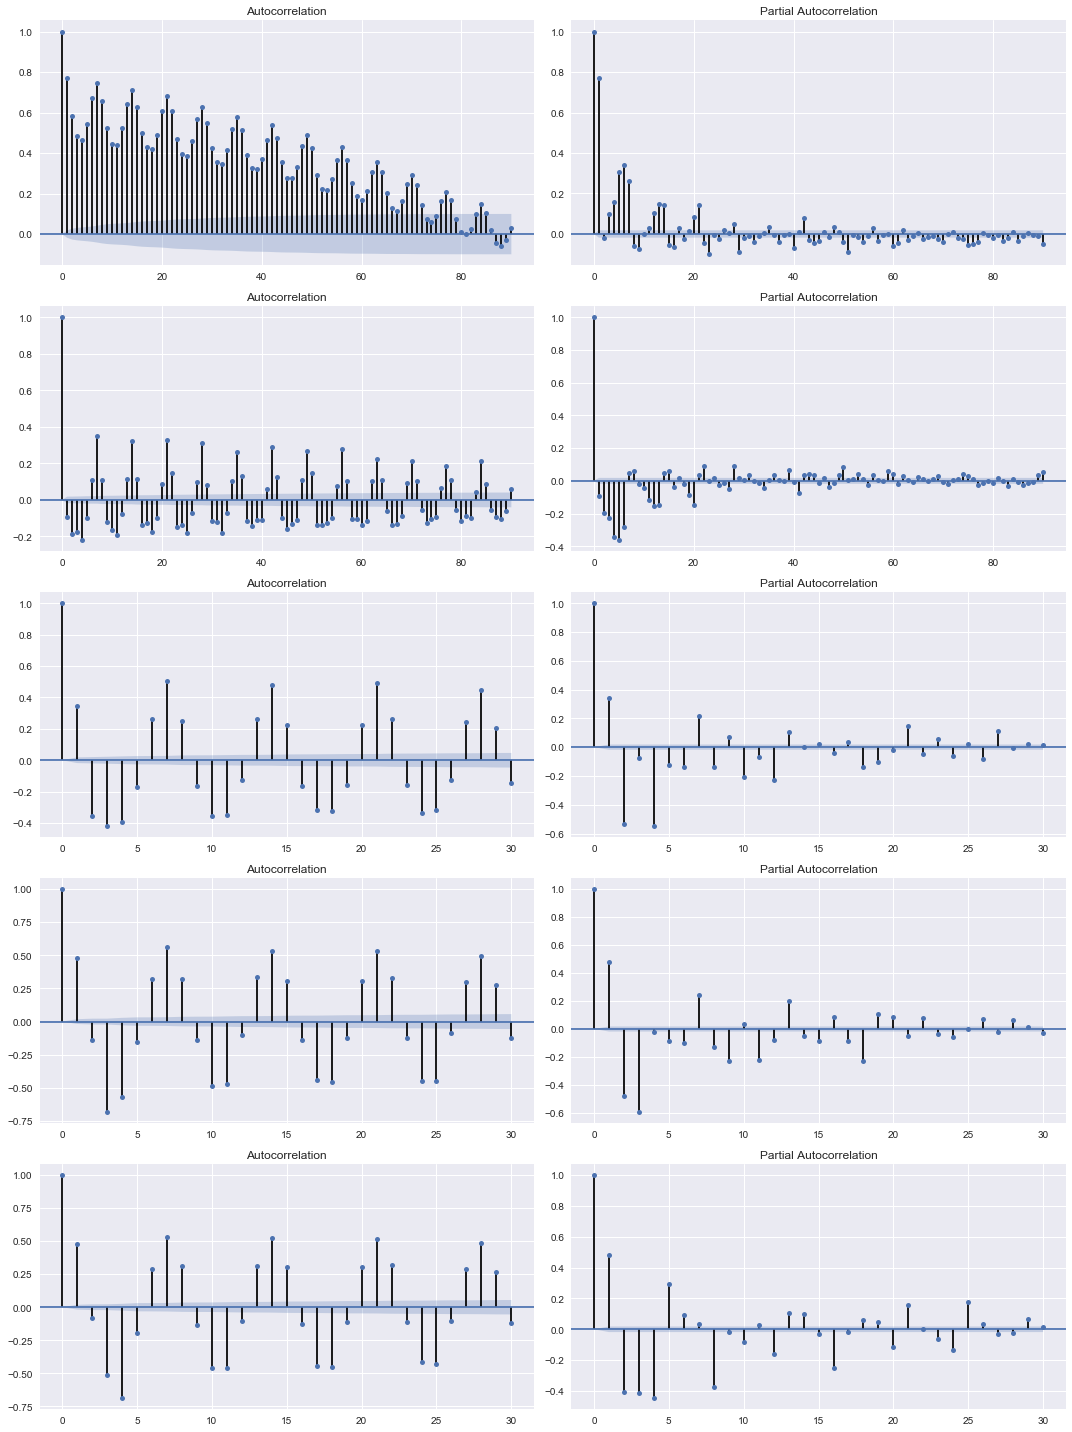

In [165]:
#ACF test
'''
ACF: A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function (ACF).
'''
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plot ACF and PCF on stationary data
#fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig, axes = plt.subplots(nrows=5, ncols=2)
fig.set_size_inches(15, 20)

plot_acf(index_df.num_trips, lags=90, ax=axes[0][0], alpha=0.5)
plot_pacf(index_df.num_trips, lags=90, ax=axes[0][1], alpha=0.5)

plot_acf(index_df.diff_num_trips_1, lags=90, ax=axes[1][0], alpha=0.5)
plot_pacf(index_df.diff_num_trips_1, lags=90, ax=axes[1][1], alpha=0.5)


plot_acf(index_df.diff_num_trips_2, lags=30, ax=axes[2][0], alpha=0.5)
plot_pacf(index_df.diff_num_trips_2, lags=30, ax=axes[2][1], alpha=0.5)

plot_acf(index_df.diff_num_trips_3, lags=30, ax=axes[3][0], alpha=0.5)
plot_pacf(index_df.diff_num_trips_3, lags=30, ax=axes[3][1], alpha=0.5)

plot_acf(index_df.diff_num_trips_4, lags=30, ax=axes[4][0], alpha=0.5)
plot_pacf(index_df.diff_num_trips_4, lags=30, ax=axes[4][1], alpha=0.5)


plt.tight_layout()



In [169]:
#timeseries data is not stationary. first make it stationary. and then split

df_monthly = index_df
df_monthly['num_trips_30mean'] = df_monthly.num_trips.resample('MS').mean()

#df_monthly['t_1'] = df_monthly.num_trips_30mean.diff(periods=1)
#df_monthly['t_2'] = df_monthly.num_trips_30mean.diff(periods=2)

df_monthly.head()

,num_trips,month,tripdate,season,IsHoliday,humidity,temperatureMax,temperatureMin,windspeed,CLEAR_DAY,...,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,diff_num_trips_1,diff_num_trips_2,diff_num_trips_3,diff_num_trips_4,humidity_scaled,num_trips_30mean
startday,,,,,,,,,,,,,,,,,,,,,
2013-08-05,64,8,5,1,0,0.71,73.41,62.73,7.32,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.073612,NaN
2013-08-06,169,8,6,1,0,0.78,81.36,67.74,7.29,1,...,0,0,0,0,105.0,0.0,0.0,0.0,0.679516,NaN
2013-08-07,117,8,7,1,0,0.77,83.63,69.75,2.13,1,...,0,0,0,0,-52.0,53.0,0.0,0.0,0.592959,NaN
2013-08-08,193,8,8,1,0,0.64,73.02,67.75,10.33,1,...,0,0,0,0,76.0,24.0,129.0,0.0,-0.532293,NaN
2013-08-09,238,8,9,1,0,0.63,78.74,64.03,1.06,1,...,0,0,0,0,45.0,121.0,69.0,174.0,-0.618851,NaN


In [25]:
#splitting data into 60%, 20% 20% ration
def train_validate_test_split(df):
    train = pd.DataFrame(df.loc['20130805':'20160131'])
    validate = pd.DataFrame(df.loc['20160201':'20160930'])
    test = pd.DataFrame(df.loc['20161001':'20170630'])
    return train, validate, test

train, validate, test = train_validate_test_split(index_df)

In [26]:
print(train.shape)
print(validate.shape)
print(test.shape)

(868, 20)
(243, 20)
(273, 20)


In [28]:
#Creating baseline on validation dataset
#mean squared error on validation data

train, validate, test = train_validate_test_split(t4)

v1 = validate
y = v1.num_trips
y_pred = rollingmean = pd.rolling_mean(v1.num_trips, window=7, min_periods=1) # v1.rollingmean

mse = mean_squared_error(y, y_pred)

print("mean squared error: %f" % mse)
print("root mean squared error: %f" % math.sqrt(mse))


mean squared error: 34406.367341
root mean squared error: 185.489534


C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()


In [201]:
#feature scaling
from sklearn import preprocessing
scaled_df = index_df.drop(['tripdate', 'diff_num_trips_1', 'diff_num_trips_2', 'diff_num_trips_3', 
                           'diff_num_trips_4', 'humidity_scaled', 'num_trips_30mean'], axis=1)

scaled_df['humidity_scaled'] = preprocessing.scale(scaled_df.humidity)
scaled_df['windspeed_scaled'] = preprocessing.scale(scaled_df.windspeed)
scaled_df['temperatureMax_scaled'] = preprocessing.scale(scaled_df.temperatureMax)
scaled_df['temperatureMin_scaled'] = preprocessing.scale(scaled_df.temperatureMin)
scaled_df.head()

,num_trips,month,season,IsHoliday,humidity,temperatureMax,temperatureMin,windspeed,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,humidity_scaled,windspeed_scaled,temperatureMax_scaled,temperatureMin_scaled
startday,,,,,,,,,,,,,,,,,,,
2013-08-05,64,8,1,0,0.71,73.41,62.73,7.32,1,0,0,0,0,0,0,0.073612,-0.243781,0.846805,0.956695
2013-08-06,169,8,1,0,0.78,81.36,67.74,7.29,1,0,0,0,0,0,0,0.679516,-0.250724,1.262318,1.231181
2013-08-07,117,8,1,0,0.77,83.63,69.75,2.13,1,0,0,0,0,0,0,0.592959,-1.444926,1.380961,1.341305
2013-08-08,193,8,1,0,0.64,73.02,67.75,10.33,1,0,0,0,0,0,0,-0.532293,0.452838,0.826421,1.231729
2013-08-09,238,8,1,0,0.63,78.74,64.03,1.06,1,0,0,0,0,0,0,-0.618851,-1.692561,1.125381,1.027919


In [239]:
#normality test
#H0: Normally distributed.
#if p > 0.05, failed to reject null-hypothesis
#=>feature is normally distributed.
import scipy
from sklearn import preprocessing

print("Before scaling\n")
print("Humidity ", scipy.stats.kstest(scaled_df.humidity, cdf='norm'))
print("windspeed ", scipy.stats.kstest(scaled_df.windspeed, cdf='norm'))
print("temperatureMax ", scipy.stats.kstest(scaled_df.temperatureMax, cdf='norm'))
print("temperatureMin ", scipy.stats.kstest(scaled_df.temperatureMin, cdf='norm'))

print("\nAfter scaling\n")
print("Humidity ", scipy.stats.kstest(scaled_df.humidity_scaled, cdf='norm'))
print("windspeed ", scipy.stats.kstest(scaled_df.windspeed_scaled, cdf='norm'))
print("temperatureMax ", scipy.stats.kstest(scaled_df.temperatureMax_scaled, cdf='norm'))
print("temperatureMin ", scipy.stats.kstest(scaled_df.temperatureMin_scaled, cdf='norm'))


Before scaling

Humidity  KstestResult(statistic=0.6612649162005404, pvalue=0.0)
windspeed  KstestResult(statistic=0.93235951921485483, pvalue=0.0)
temperatureMax  KstestResult(statistic=0.99999999400962858, pvalue=0.0)
temperatureMin  KstestResult(statistic=0.98410789103063689, pvalue=0.0)

After scaling

Humidity  KstestResult(statistic=0.028906489995124574, pvalue=0.19415760270750249)
windspeed  KstestResult(statistic=0.039444283669713975, pvalue=0.026237781215208367)
temperatureMax  KstestResult(statistic=0.080821253488255973, pvalue=2.6003142972186311e-08)
temperatureMin  KstestResult(statistic=0.067694928851632974, pvalue=5.8586093756307633e-06)


In [246]:
#Normalize temperature
t1 = preprocessing.normalize(scaled_df.temperatureMax, axis=1)
t2 = preprocessing.normalize(scaled_df.temperatureMin, axis=1)
shapiro_results1 = scipy.stats.kstest(t1, cdf='norm')
shapiro_results2 = scipy.stats.kstest(t2, cdf='norm')

print(shapiro_results1)
print(shapiro_results1)


KstestResult(statistic=0.51659546068731255, pvalue=0.95232763262345643)
KstestResult(statistic=0.51659546068731255, pvalue=0.95232763262345643)
[[ 0.03271191  0.03625448  0.037266   ...,  0.03506916  0.03574203
   0.03355411]]


C:\_Apps\Anaconda\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\_Apps\Anaconda\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [258]:
scaled_norm_df = scaled_df#.drop(['temperatureMax', 'temperatureMin'], axis=1)
#scaled_norm_df['tempMax_norm'] = t1
#scaled_norm_df['tempMin_norm'] = t2
scaled_norm_df['tempMax_norm'] = np.transpose(t1)
scaled_norm_df['tempMin_norm'] = np.transpose(t2)
scaled_norm_df.head()
scaled_norm_df = scaled_norm_df.drop(['temperatureMax', 'temperatureMin', 'humidity', 'windspeed', 
                                      'temperatureMax_scaled', 'temperatureMin_scaled'], axis=1)
scaled_norm_df.head()

,num_trips,month,season,IsHoliday,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,humidity_scaled,windspeed_scaled,num_trips_90mean,tempMax_norm,tempMin_norm
startday,,,,,,,,,,,,,,,,
2013-08-05,64,8,1,0,1,0,0,0,0,0,0,0.073612,-0.243781,NaN,0.032712,0.034547
2013-08-06,169,8,1,0,1,0,0,0,0,0,0,0.679516,-0.250724,NaN,0.036254,0.037306
2013-08-07,117,8,1,0,1,0,0,0,0,0,0,0.592959,-1.444926,NaN,0.037266,0.038413
2013-08-08,193,8,1,0,1,0,0,0,0,0,0,-0.532293,0.452838,NaN,0.032538,0.037311
2013-08-09,238,8,1,0,1,0,0,0,0,0,0,-0.618851,-1.692561,NaN,0.035087,0.035262


In [325]:
scaled_norm_df['num_trips_90mean'] = pd.rolling_mean(scaled_norm_df.num_trips, window=90, min_periods=1)
scaled_norm_df.to_csv('C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\SPSSData.csv')


C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,min_periods=1,center=False).mean()
  if __name__ == '__main__':


In [186]:
##save data till here.

temp_df = index_df.drop(['diff_num_trips_1', 'diff_num_trips_2', 'diff_num_trips_3', 'diff_num_trips_4'], axis=1)
temp_df1 = temp_df.drop(['humidity_scaled', 'num_trips_30mean'], axis=1)
temp_df1.head()

temp_df1.to_csv('C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\modeldata.csv')

In [287]:
model_df.columns

Index(['month', 'season', 'IsHoliday', 'humidity', 'temperatureMax',
       'temperatureMin', 'windspeed', 'CLEAR_DAY', 'FOG', 'PARTLY_CLOUDY_DAY',
       'PARTLY_CLOUDY_NIGHT', 'RAIN', 'SNOW', 'WIND', 'diff_num_trips_1'],
      dtype='object')

In [286]:
model_df = index_df.drop(['tripdate','diff_num_trips_2', 'diff_num_trips_3', 'diff_num_trips_4', 
                          'humidity_scaled', 'num_trips_30mean',], axis=1)

#model_df['num_trips_90mean'] = model_df.num_trips.rolling(window=90, min_periods=7, center=False).mean()
model_df = model_df.drop(['num_trips'], axis=1)

model_df.dropna(inplace=True)
model_train, model_validate, model_test = train_validate_test_split(model_df)

#train data
model_train = model_train.reset_index('startday')
model_train = model_train.drop('startday', axis=1)
X_train = model_train.drop('diff_num_trips_1',axis=1)
Y_train = model_train['diff_num_trips_1']

#validate data
model_validate = model_validate.reset_index('startday')
model_validate = model_validate.drop('startday', axis=1)
X_val = model_validate.drop('diff_num_trips_1',axis=1)
Y_val = model_validate['diff_num_trips_1']

#test data
model_test = model_test.reset_index('startday')
model_test = model_test.drop('startday', axis=1)
X_test = model_test.drop('diff_num_trips_1',axis=1)
Y_test = model_test['diff_num_trips_1']

X_train.dtypes

month                  category
season                 category
IsHoliday              category
humidity                float64
temperatureMax          float64
temperatureMin          float64
windspeed               float64
CLEAR_DAY              category
FOG                    category
PARTLY_CLOUDY_DAY      category
PARTLY_CLOUDY_NIGHT    category
RAIN                   category
SNOW                   category
WIND                   category
dtype: object

In [283]:
model_df.columns

Index(['month', 'season', 'IsHoliday', 'humidity', 'temperatureMax',
       'temperatureMin', 'windspeed', 'CLEAR_DAY', 'FOG', 'PARTLY_CLOUDY_DAY',
       'PARTLY_CLOUDY_NIGHT', 'RAIN', 'SNOW', 'WIND', 'num_trips_90mean'],
      dtype='object')

In [288]:
#Linear regression model understanding with original data , without scaling
clf = LinearRegression(normalize= True)
clf.fit(X_train, Y_train)
rmse = math.sqrt(mean_squared_error(Y_val, clf.predict(X_val)))
print("Accuracy of LR is: ", clf.score(X_val, Y_val), 
      "\nThe RMSE is: ", rmse)
print("cofficient: " , clf.coef_)
print("intercepter: ", clf.intercept_)

Accuracy of LR is:  0.0477763444894 
The RMSE is:  194.63076851931268
cofficient:  [  0.1477003   -4.0672383   -0.59392361 -48.91682927   0.91957926
  -0.87077178  -0.93517657  24.86811212  19.55376646   8.7838501
   9.38384641 -61.37071985   9.50610606  -8.6693995 ]
intercepter:  31.3355073585


In [289]:
#with original data , without scaling
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200,random_state=0)
rf.fit(X_train, Y_train)
rf.score(X_val, Y_val)
preds = rf.predict(X= X_val)

rmse = math.sqrt(mean_squared_error(Y_val, preds))
print ("RMSE Value For Random Forest: ", rmse)
print("Accuracy: ", rf.score(X_val, Y_val))

RMSE Value For Random Forest:  195.26995314972518
Accuracy:  0.0415117013936


In [128]:
#fit with ARIMA model 

float_num_trips = index_df.num_trips.apply(lambda x : float(x))

float_num_trips_1 = index_df.diff_num_trips_1.apply(lambda x : float(x))
float_num_trips_1.dropna(inplace=True)

from statsmodels.tsa.arima_model import ARIMA 
model = ARIMA(float_num_trips, order=(1, 0, 1))
results_ARIMA = model.fit(disp=-1)

model = ARIMA(float_num_trips_1, order=(1, 1, 0))
results_ARIMA1 = model.fit(disp=-1)


#plt.plot(float_num_trips) 
#plt.plot(results_ARIMA.fittedvalues, color='red') 
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-float_num_trips)**2))
print(results_ARIMA.summary())
print(results_ARIMA1.summary())

                              ARMA Model Results                              
Dep. Variable:              num_trips   No. Observations:                 1384
Model:                     ARMA(1, 1)   Log Likelihood               -8771.367
Method:                       css-mle   S.D. of innovations            136.787
Date:                Sat, 18 Nov 2017   AIC                          17550.733
Time:                        18:37:31   BIC                          17571.664
Sample:                    08-05-2013   HQIC                         17558.562
                         - 06-30-2017                                         
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const             191.4475     15.554     12.308      0.000       160.962   221.933
ar.L1.num_trips     0.7551      0.024     31.359      0.000         0.708     0.802
ma.L1.num_trips     0.0384      

In [292]:
#creating new feature for lag with 90days
model_df1 = scaled_norm_df
model_df2 = scaled_norm_df

model_df1['num_trips_90mean'] = model_df1.num_trips.rolling(window=90, min_periods=7, center=False).mean()
model_df1 = model_df1.drop(['num_trips'], axis=1)
model_df1.dropna(inplace=True)

model_df2['diff_num_trips_1'] = model_df2.num_trips.diff(periods=1)
model_df2 = model_df2.drop(['num_trips'], axis=1)
model_df2.dropna(inplace=True)
model_df2.head()

,month,season,IsHoliday,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,humidity_scaled,windspeed_scaled,num_trips_90mean,tempMax_norm,tempMin_norm,diff_num_trips_1
startday,,,,,,,,,,,,,,,,
2013-08-17,8,1,0,1,0,0,0,0,0,0,-0.532293,-0.690449,242.000000,0.033616,0.034844,242.0
2013-08-18,8,1,0,1,0,0,0,0,0,0,-0.359177,-0.789966,262.375000,0.033839,0.035615,-86.0
2013-08-19,8,1,0,1,0,0,0,0,0,0,-0.532293,-1.484270,264.777778,0.035042,0.035653,-121.0
2013-08-20,8,1,0,1,0,0,0,0,0,0,-0.618851,-0.482158,260.500000,0.037948,0.038016,-62.0
2013-08-21,8,1,0,1,0,0,0,0,0,0,-0.705409,-0.158150,255.636364,0.039458,0.038754,-15.0


In [309]:
model_df2.corr()

,humidity_scaled,windspeed_scaled,num_trips_90mean,tempMax_norm,tempMin_norm,diff_num_trips_1
humidity_scaled,1.000000,-0.082571,0.109835,-0.010491,0.095939,-0.100073
windspeed_scaled,-0.082571,1.000000,-0.181546,-0.233633,-0.262122,-0.071612
num_trips_90mean,0.109835,-0.181546,1.000000,0.625139,0.676859,-0.018953
tempMax_norm,-0.010491,-0.233633,0.625139,1.000000,0.954045,-0.005722
tempMin_norm,0.095939,-0.262122,0.676859,0.954045,1.000000,-0.023319
diff_num_trips_1,-0.100073,-0.071612,-0.018953,-0.005722,-0.023319,1.000000


In [260]:
#save scaled data
scaled_norm_df.to_csv('C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\modeldata_scaled_norm.csv')


C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()


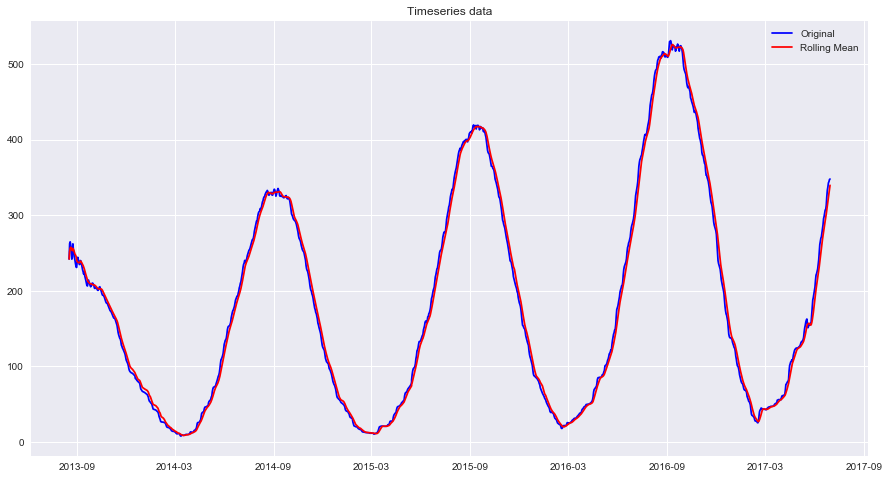

ADF Test result:
ADF Statistic: -6.492247
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [293]:
#stationary ADF test on 90days rolling data
model_df1.num_trips_90mean.dropna(inplace=True)
isStationary(model_df1.num_trips_90mean)

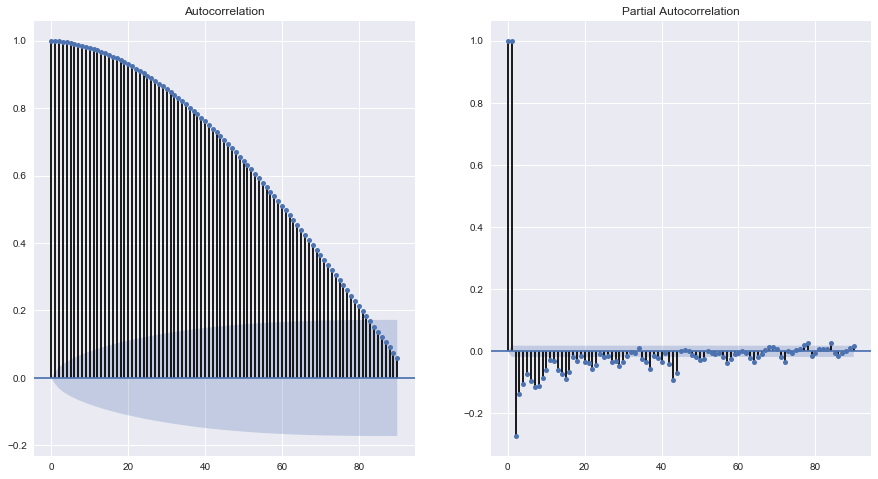

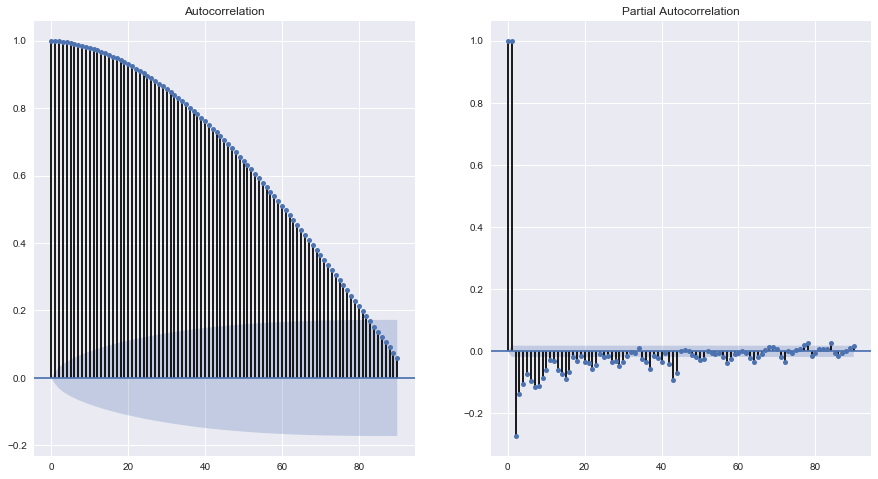

In [67]:
#ACF/PCF plot on 90days mean data.
#fig, axes = plt.subplots(nrows=1, ncols=2)
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_size_inches(15, 8)
plot_acf(model_df1.num_trips_90mean, lags=90, ax=axes[0],  alpha=0.5)
plot_pacf(model_df1.num_trips_90mean, lags=90,  ax=axes[1],  alpha=0.5)


In [297]:
#split data into training, validation, & testing set

temp_df1 = model_df2
model_train, model_validate, model_test = train_validate_test_split(temp_df1)

#train data
model_train = model_train.reset_index('startday')
model_train = model_train.drop('startday', axis=1)
X_train = model_train.drop('diff_num_trips_1',axis=1)
Y_train = model_train['diff_num_trips_1']

#validate data
model_validate = model_validate.reset_index('startday')
model_validate = model_validate.drop('startday', axis=1)
X_val = model_validate.drop('diff_num_trips_1',axis=1)
Y_val = model_validate['diff_num_trips_1']

#test data
model_test = model_test.reset_index('startday')
model_test = model_test.drop('startday', axis=1)
X_test = model_test.drop('diff_num_trips_1',axis=1)
Y_test = model_test['diff_num_trips_1']

X_train.dtypes

month                  category
season                 category
IsHoliday              category
CLEAR_DAY              category
FOG                    category
PARTLY_CLOUDY_DAY      category
PARTLY_CLOUDY_NIGHT    category
RAIN                   category
SNOW                   category
WIND                   category
humidity_scaled         float64
windspeed_scaled        float64
num_trips_90mean        float64
tempMax_norm            float64
tempMin_norm            float64
dtype: object

In [296]:
X_train.head()

,month,season,IsHoliday,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,humidity_scaled,windspeed_scaled,num_trips_90mean,tempMax_norm,tempMin_norm
0,8,1,0,1,0,0,0,0,0,0,-0.532293,-0.690449,242.000000,0.033616,0.034844
1,8,1,0,1,0,0,0,0,0,0,-0.359177,-0.789966,262.375000,0.033839,0.035615
2,8,1,0,1,0,0,0,0,0,0,-0.532293,-1.484270,264.777778,0.035042,0.035653
3,8,1,0,1,0,0,0,0,0,0,-0.618851,-0.482158,260.500000,0.037948,0.038016
4,8,1,0,1,0,0,0,0,0,0,-0.705409,-0.158150,255.636364,0.039458,0.038754


In [298]:
#Linear regression model understanding after scalling and rolling mean on 90 days
clf = LinearRegression(normalize= True)
clf.fit(X_train, Y_train)
rmse = math.sqrt(mean_squared_error(Y_val, clf.predict(X_val)))
print("Accuracy of LR is: ", clf.score(X_val, Y_val), 
      "\nThe RMSE is: ", rmse)
print("cofficient: " , clf.coef_)
print("intercepter: ", clf.intercept_)

Accuracy of LR is:  0.047855848217 
The RMSE is:  194.62264322515617
cofficient:  [  3.32042540e-01  -3.62350874e+00  -7.66101138e-01   2.48866353e+01
   1.88126529e+01   8.89622166e+00   9.54095511e+00  -6.15197657e+01
   9.31469695e+00  -8.14165372e+00  -5.63063922e+00  -4.75592152e+00
  -1.21325074e-02   2.18588053e+03  -1.58616419e+03]
intercepter:  -13.7100284862


In [299]:
# after scalling and rolling mean on 90 days
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200,random_state=0)
rf.fit(X_train, Y_train)
rf.score(X_val, Y_val)
preds = rf.predict(X= X_val)

rmse = math.sqrt(mean_squared_error(Y_val, preds))
print ("RMSE Value For Random Forest: ", rmse)
print("Accuracy: ", rf.score(X_val, Y_val))

RMSE Value For Random Forest:  194.06131038083916
Accuracy:  0.0533402976537


tempMax_norm           0.196390
tempMin_norm           0.187493
windspeed_scaled       0.169279
num_trips_90mean       0.154248
humidity_scaled        0.124150
RAIN                   0.050583
month                  0.045803
season                 0.020620
CLEAR_DAY              0.018944
PARTLY_CLOUDY_DAY      0.011263
PARTLY_CLOUDY_NIGHT    0.007502
WIND                   0.006166
FOG                    0.004826
IsHoliday              0.002707
SNOW                   0.000027
dtype: float64


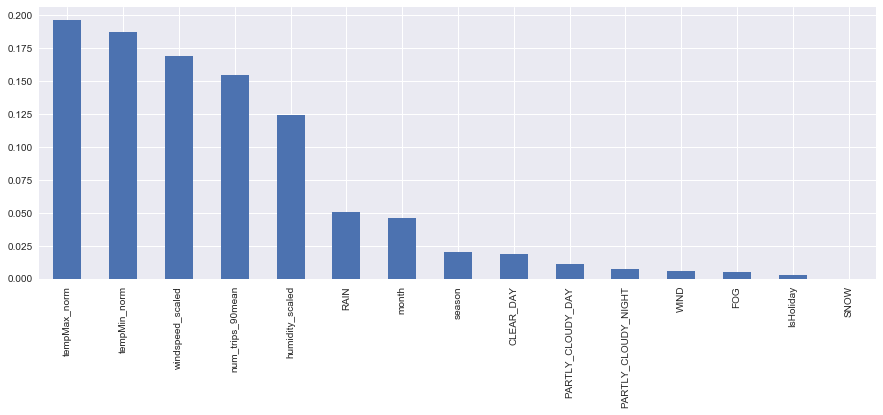

In [308]:
important_features = pd.Series(data=rf.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

#plt.scatter(y=important_features[1], x=important_features[0])
type(important_features)
important_features.plot(kind='bar', figsize=(15,5))

In [215]:
#fit with ARIMA model 
temp_df = model_df1
float_num_trips = temp_df.num_trips_90mean.apply(lambda x : float(x))

float_num_trips_1 = temp_df.num_trips_90mean.apply(lambda x : float(x))
float_num_trips_1.dropna(inplace=True)

model = ARIMA(float_num_trips, order=(0, 0, 0))
results_ARIMA = model.fit(disp=-1)

model = ARIMA(float_num_trips_1, order=(0, 0, 0))
results_ARIMA1 = model.fit(disp=-1)

print(results_ARIMA.summary())
print(results_ARIMA1.summary())

                              ARMA Model Results                              
Dep. Variable:       num_trips_90mean   No. Observations:                 1378
Model:                     ARMA(0, 0)   Log Likelihood               -8788.789
Method:                           css   S.D. of innovations            142.450
Date:                Wed, 22 Nov 2017   AIC                          17581.578
Time:                        12:26:19   BIC                          17592.035
Sample:                    08-11-2013   HQIC                         17585.490
                         - 06-30-2017                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        184.4808      3.837     48.074      0.000       176.960   192.002
                             ARIMA Model Results                              
Dep. Variable:     D.num_trips_90mean   No. Observat

C:\_Apps\Anaconda\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


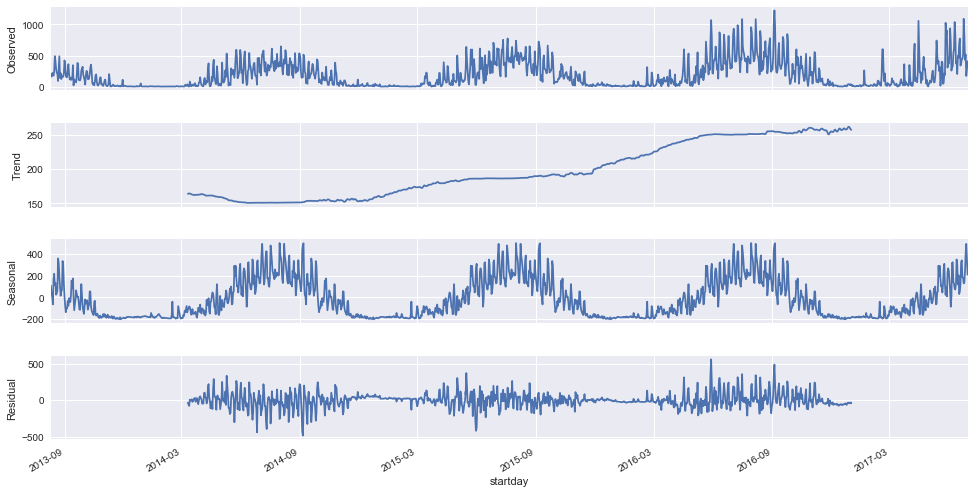

In [336]:
import statsmodels.api as sm

#mean30 = pd.rolling_mean(scaled_norm_df.num_trips, window=30,min_periods=1)
decomposition = sm.tsa.seasonal_decompose(scaled_norm_df.num_trips, freq=12*30)

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)


In [312]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41

gbm.fit(X_train,Y_train)
preds = gbm.predict(X= X_test)
msse = math.sqrt(mean_squared_error(Y_test, preds))
print ("RMSLE Value For Gradient Boost: ", msse)
plt.scatter(Y_test, y_pred)

RMSLE Value For Gradient Boost:  190.56809094339008


-0.0411311117442


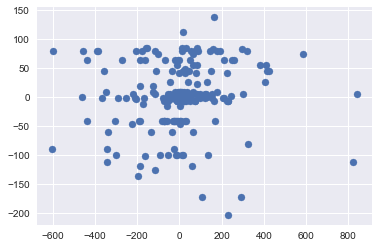

In [315]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor()
model.fit(X_train, Y_train)

print(model.score(X_test, Y_test))
y_pred = model.predict(X_test)

plt.scatter(Y_test, y_pred)


In [ ]:
# Evaluate and visualize the fit
print("Mean Squared Error: %.4f"
      % np.mean((grid.predict(X) - y) ** 2))
print('Variance Score: %.4f' % grid.score(X, y))

with plt.style.context(('seaborn-whitegrid')):
    plt.scatter(X, y, c='lightgray')
    plt.plot(X, grid.predict(X), c='darkgreen', lw=2)

plt.show()

In [344]:
d1 = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\modeldata_scaled_norm.csv")
d1.head()
d2 = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\Table (6 fields, 1,420 records) _1.csv")
d2 = d2.drop(['$FutureFlag', 'num_trips','$TSLCI-num_trips','$TSUCI-num_trips'], axis=1)

d2 = d2.rename(columns={'$TS-num_trips':'num_trips_TS'})
d2.head()

 

,startday,num_trips_TS
0,2013-08-11,$null$
1,2013-08-12,337.080
2,2013-08-13,265.798
3,2013-08-14,266.196
4,2013-08-15,283.058


In [348]:
d3 = pd.concat([d1, d2], axis=1)
d3.head()

,startday,num_trips,month,season,IsHoliday,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,humidity_scaled,windspeed_scaled,num_trips_90mean,tempMax_norm,tempMin_norm,startday,num_trips_TS
0,2013-08-11,212.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.359177,-1.653218,195.428571,0.034044,0.035576,2013-08-11,$null$
1,2013-08-12,161.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.246727,-0.998258,191.125000,0.036455,0.038247,2013-08-12,337.080
2,2013-08-13,181.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.532293,0.911078,190.000000,0.030970,0.034563,2013-08-13,265.798
3,2013-08-14,222.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.618851,-0.570103,193.200000,0.029891,0.033368,2013-08-14,266.196
4,2013-08-15,178.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.532293,-1.060745,191.818182,0.032271,0.032008,2013-08-15,283.058


In [357]:
d3.num_trips_TS.dropna(inplace=True, axis=0)
d3 = d3.iloc[1:]
d3.head()

,num_trips,month,season,IsHoliday,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,humidity_scaled,windspeed_scaled,num_trips_90mean,tempMax_norm,tempMin_norm,num_trips_TS
1,161.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.246727,-0.998258,191.125000,0.036455,0.038247,337.080
2,181.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.532293,0.911078,190.000000,0.030970,0.034563,265.798
3,222.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.618851,-0.570103,193.200000,0.029891,0.033368,266.196
4,178.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.532293,-1.060745,191.818182,0.032271,0.032008,283.058
5,249.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.791967,-1.477327,196.583333,0.033897,0.034144,260.297


In [518]:
print(math.sqrt(mean_squared_error(d3.tail(10).num_trips, d3.tail(10).num_trips_TS)))


355.6168522823406


In [365]:
p1 = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\SarimaxPrediction.csv")
p1 = p1.drop(['startday', 'num_trips_90mean','residual','humidity', 'temperatureMax','temperatureMin','windspeed'], axis=1)
p1.head()

,num_trips,month,season,IsHoliday,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,humidity_scaled,windspeed_scaled,temperatureMax_scaled,temperatureMin_scaled,prediction
0,212,8,1,0,1,0,0,0,0,0,0,-0.359177,-1.653218,1.003080,1.059148,0.000000
1,161,8,1,0,0,0,0,0,1,0,0,0.246727,-0.998258,1.285837,1.324869,211.585679
2,181,8,1,0,0,0,0,0,0,0,1,-0.532293,0.911078,0.642446,0.958338,165.799408
3,222,8,1,0,1,0,0,0,0,0,0,-0.618851,-0.570103,0.515963,0.839449,179.117879
4,178,8,1,0,1,0,0,0,0,0,0,-0.532293,-1.060745,0.795062,0.704123,218.141653


In [373]:
p1 = p1.iloc[1:]
p1.head()

,num_trips,month,season,IsHoliday,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,humidity_scaled,windspeed_scaled,temperatureMax_scaled,temperatureMin_scaled,prediction
1,161,8,1,0,0,0,0,0,1,0,0,0.246727,-0.998258,1.285837,1.324869,211.585679
2,181,8,1,0,0,0,0,0,0,0,1,-0.532293,0.911078,0.642446,0.958338,165.799408
3,222,8,1,0,1,0,0,0,0,0,0,-0.618851,-0.570103,0.515963,0.839449,179.117879
4,178,8,1,0,1,0,0,0,0,0,0,-0.532293,-1.060745,0.795062,0.704123,218.141653
5,249,8,1,0,1,0,0,0,0,0,0,-0.791967,-1.477327,0.985832,0.916699,182.140665


In [520]:
print(math.sqrt(mean_squared_error(p1.tail(10).num_trips, p1.tail(10).prediction)))


268.2838856395792


In [368]:
categoricalVariables = ["month","season","IsHoliday", "CLEAR_DAY", "FOG", "PARTLY_CLOUDY_DAY", "PARTLY_CLOUDY_NIGHT",
                       "RAIN", "SNOW", "WIND"]
for var in categoricalVariables:
    p1[var] = p1[var].astype("category")

p1.dtypes

num_trips                   int64
month                    category
season                   category
IsHoliday                category
CLEAR_DAY                category
FOG                      category
PARTLY_CLOUDY_DAY        category
PARTLY_CLOUDY_NIGHT      category
RAIN                     category
SNOW                     category
WIND                     category
humidity_scaled           float64
windspeed_scaled          float64
temperatureMax_scaled     float64
temperatureMin_scaled     float64
prediction                float64
dtype: object

In [369]:
p1.corr()

,num_trips,humidity_scaled,windspeed_scaled,temperatureMax_scaled,temperatureMin_scaled,prediction
num_trips,1.000000,-0.164775,-0.283173,0.702365,0.686130,0.768587
humidity_scaled,-0.164775,1.000000,-0.080846,-0.011865,0.094069,-0.091862
windspeed_scaled,-0.283173,-0.080846,1.000000,-0.236144,-0.264291,-0.236272
temperatureMax_scaled,0.702365,-0.011865,-0.236144,1.000000,0.954146,0.717198
temperatureMin_scaled,0.686130,0.094069,-0.264291,0.954146,1.000000,0.714041
prediction,0.768587,-0.091862,-0.236272,0.717198,0.714041,1.000000


In [374]:
#Split data method
from sklearn.model_selection import train_test_split
temp_df1 = p1


In [521]:
#split data into training, validation, & testing set

#train data

X = temp_df1.drop('num_trips',axis=1)
Y = temp_df1['num_trips']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.40)

print(X_train.shape)
print(X_test.shape)

(826, 15)
(551, 15)


RMSLE Value For Gradient Boost:  141.01483923139998
accuracy:  0.58685783401


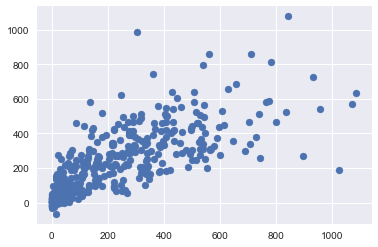

In [386]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01);

gbm.fit(X_train,y_train)
preds = gbm.predict(X= X_test)
msse = math.sqrt(mean_squared_error(y_test, preds))
print ("RMSLE Value For Gradient Boost: ", msse)
print("accuracy: " , gbm.score(X_test, y_test))
plt.scatter(y_test, preds)

In [414]:
# after scalling and rolling mean on 90 days
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200,random_state=0)
rf.fit(X_train, y_train)
score1 = rf.score(X_test, y_test)
preds = rf.predict(X= X_test)

rmse = math.sqrt(mean_squared_error(y_test, preds))
print ("RMSE Value For Random Forest: ", rmse)
print("Accuracy: ", score1)

RMSE Value For Random Forest:  135.06125816403156
Accuracy:  0.599497195901


Mean Squared Error: 58676.8176
Variance Score: -0.2191


ValueError: x and y must be the same size

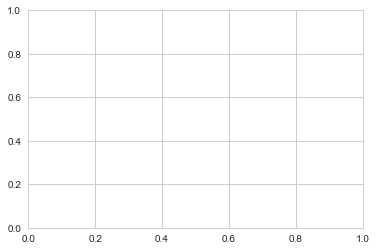

In [399]:
lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
svr_rbf = SVR(kernel='rbf')

stregr = StackingRegressor(regressors=[svr_lin, lr, ridge], 
                           meta_regressor=svr_rbf)

# Training the stacking classifier

stregr.fit(X_train, y_train)
stregr.predict(X_test)

# Evaluate and visualize the fit

print("Mean Squared Error: %.4f"
      % np.mean((stregr.predict(X_test) - y_test) ** 2))
print('Variance Score: %.4f' % stregr.score(X_test, y_test))

with plt.style.context(('seaborn-whitegrid')):
    plt.scatter(X_train, y_train, c='lightgray')
    plt.plot(y_test, stregr.predict(X_test), c='darkgreen', lw=2)

plt.show()

In [408]:
X_train.head()

,month,season,IsHoliday,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,humidity_scaled,windspeed_scaled,temperatureMax_scaled,temperatureMin_scaled,prediction
1283,3,0,0,0,1,0,0,0,0,0,1.631653,0.806933,-0.710714,-0.445325,43.046559
1037,7,1,0,0,0,1,0,0,0,0,-0.186062,-1.646274,1.196986,1.580727,242.844980
1270,3,3,0,1,0,0,0,0,0,0,-1.570987,0.779160,-1.337903,-1.466021,2.188212
693,8,1,0,0,0,1,0,0,0,0,-0.012946,-0.829310,0.827989,1.186803,416.046559
379,9,2,0,1,0,0,0,0,0,0,0.160170,-1.273665,0.693666,0.715080,198.565623


In [401]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Initializing models

lr = RandomForestRegressor()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
lasso = Lasso(random_state=1)
svr_rbf = SVR(kernel='rbf')
regressors = [svr_lin, lr, ridge, lasso]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=svr_rbf)

params = {'lasso__alpha': [0.1, 1.0, 10.0],
          'ridge__alpha': [0.1, 1.0, 10.0],
          'svr__C': [0.1, 1.0, 10.0],
          'meta-svr__C': [0.1, 1.0, 10.0, 100.0],
          'meta-svr__gamma': [0.1, 1.0, 10.0]}

grid = GridSearchCV(estimator=stregr, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X_train, y_train)

for params, mean_score, scores in grid.grid_scores_:
        print("%0.3f +/- %0.2f %r"
              % (mean_score, scores.std() / 2.0, params))


-0.176 +/- 0.02 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 0.1, 'svr__C': 0.1}
-0.176 +/- 0.02 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 0.1, 'svr__C': 1.0}
-0.176 +/- 0.02 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 0.1, 'svr__C': 10.0}
-0.176 +/- 0.02 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 1.0, 'svr__C': 0.1}
-0.176 +/- 0.02 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 1.0, 'svr__C': 1.0}
-0.176 +/- 0.02 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 1.0, 'svr__C': 10.0}
-0.176 +/- 0.02 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 10.0, 'svr__C': 0.1}
-0.176 +/- 0.02 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 10.0, 'svr__C': 1.0}
-0.176 +/- 0.02 {'lasso__alpha': 0.1, 'meta-svr__C':

C:\_Apps\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Mean Squared Error: 51460.3905
Variance Score: -0.0692
226.84882740514365


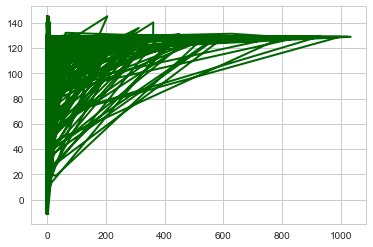

In [407]:
# Evaluate and visualize the fit
print("Mean Squared Error: %.4f"
      % np.mean((grid.predict(X_test) - y_test) ** 2))
print('Variance Score: %.4f' % grid.score(X_test, y_test))
print(math.sqrt(mean_squared_error(grid.predict(X_test), y_test)))
with plt.style.context(('seaborn-whitegrid')):
    #plt.scatter(X_test, y_test, c='lightgray')
    plt.plot(X_test, grid.predict(X_test), c='darkgreen', lw=2)

plt.show()

In [542]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [547]:
pred= clf.predict(X_test)

print("Mean Squared Error: %.4f"
      % math.sqrt(np.mean((pred - y_test) ** 2)))
print('Variance Score: %.4f' % clf.score(X_test, y_test))


Mean Squared Error: 209.4544
Variance Score: 0.0326


In [435]:
#########################################################################
p2 = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\SarimaxPrediction1.csv")
p2 = p2.drop(['startday', 'num_trips_90mean','residual','humidity', 'temperatureMax','temperatureMin',
              'windspeed'], axis=1)
p2 = p2.iloc[1:]
for var in categoricalVariables:
    p2[var] = p2[var].astype("category")

#p2 = p2.rename(columns={'diff_num_trips_1' : 'num_trips'})
p2.dtypes

num_trips                   int64
month                    category
season                   category
IsHoliday                category
CLEAR_DAY                category
FOG                      category
PARTLY_CLOUDY_DAY        category
PARTLY_CLOUDY_NIGHT      category
RAIN                     category
SNOW                     category
WIND                     category
humidity_scaled           float64
windspeed_scaled          float64
temperatureMax_scaled     float64
temperatureMin_scaled     float64
prediction                float64
dtype: object

In [523]:
print(math.sqrt(mean_squared_error(p2.tail(10).num_trips, p2.tail(10).prediction)))


274.4138009575912


In [531]:
temp_df2 = p2
#temp_df2 = temp_df2.drop(['FOG', 'SNOW'], axis=1)
X = temp_df2.drop('num_trips',axis=1)
Y = temp_df2['num_trips']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

print(X_train.shape)
print(X_test.shape)

(1101, 15)
(276, 15)


In [525]:
# after scalling and rolling mean on 90 days
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200,random_state=0)
rf.fit(X_train, y_train)
score1 = rf.score(X_test, y_test)
preds = rf.predict(X= X_test)

rmse = math.sqrt(mean_squared_error(y_test, preds))
print ("RMSE Value For Random Forest: ", rmse)
print("Accuracy: ", score1)

RMSE Value For Random Forest:  109.47182103543916
Accuracy:  0.727370608948


prediction               0.417889
temperatureMax_scaled    0.322528
temperatureMin_scaled    0.072186
windspeed_scaled         0.057107
humidity_scaled          0.052480
month                    0.025504
RAIN                     0.021377
CLEAR_DAY                0.009062
PARTLY_CLOUDY_DAY        0.007475
season                   0.006496
PARTLY_CLOUDY_NIGHT      0.004086
WIND                     0.002717
IsHoliday                0.001093
dtype: float64


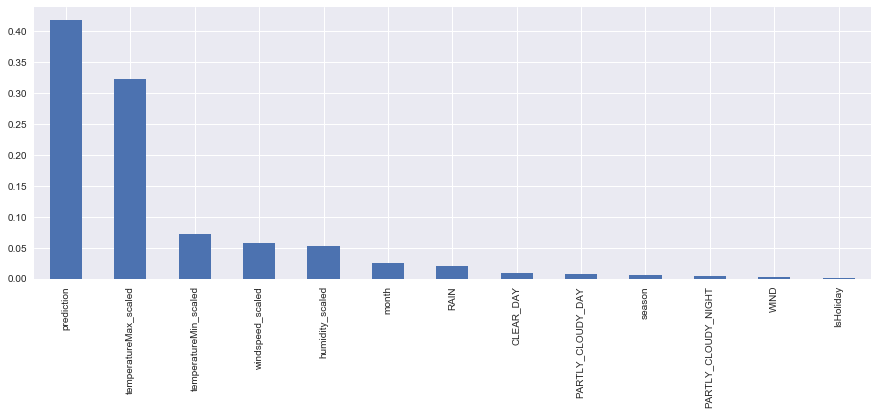

In [440]:
important_features = pd.Series(data=rf.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

#plt.scatter(y=important_features[1], x=important_features[0])
type(important_features)
important_features.plot(kind='bar', figsize=(15,5))

In [533]:
testDataDaily = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\testDataDaily2.csv")
testDataDaily.head()

,startday,weather,humidity,temperatureMax,temperatureMin,windspeed
0,2017-07-01,PARTLY_CLOUDY_DAY,0.64,80.09,67.32,7.56
1,2017-07-02,PARTLY_CLOUDY_DAY,0.63,85.18,63.28,5.54


In [534]:

#testDataDaily['humidity'] = testDataDaily['humidity'].astype(np.float)
w_df = pd.get_dummies(testDataDaily['weather'])
#testDataDaily.head()
testDataDaily = pd.concat([testDataDaily, w_df],axis=1)
testDataDaily = testDataDaily.drop(['weather'], axis=1)
testDataDaily.head()

,startday,humidity,temperatureMax,temperatureMin,windspeed,PARTLY_CLOUDY_DAY
0,2017-07-01,0.64,80.09,67.32,7.56,1
1,2017-07-02,0.63,85.18,63.28,5.54,1


In [540]:
testNextDay = train_df.head(2)
testNextDay['prediction'] =386
testNextDay.head()

C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,humidity,temperatureMax,temperatureMin,windspeed,CLEAR_DAY,PARTLY_CLOUDY_DAY,RAIN,prediction,PARTLY_CLOUDY_NIGHT,WIND,month,IsHoliday,season
0,0.64,80.09,67.32,7.56,0,1,0,386,0,0,7,1,1
1,0.63,85.18,63.28,5.54,0,1,0,386,0,0,7,1,1


In [541]:
preds = rf.predict(X= testNextDay)
print("prediction: ", preds)

rmse = math.sqrt(mean_squared_error(testNextDay['prediction'], preds))

print ("RMSE Value For Random Forest: ", rmse)


prediction:  [ 282.095  282.095]
RMSE Value For Random Forest:  103.90499999999997
